<a href="https://colab.research.google.com/github/brillantescene/Capstone_Design/blob/master/cnn_ing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow import keras #import keras
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D

Using TensorFlow backend.


In [0]:
import pathlib

In [5]:
data_dir = tf.keras.utils.get_file(origin='https://github.com/CapstoneDesign2020/machineLearning/raw/master/dataPreprocessing/images.tgz', 
                                   fname='acoustic_images', extract=True)
data_dir = pathlib.Path(data_dir)

4161536/4156416 [==============================] - 0s 0us/step


In [0]:
data_dir = pathlib.PosixPath("/root/.keras/datasets/images")

In [7]:
print(data_dir)

/root/.keras/datasets/images


In [8]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

200

In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['clock_alarm', 'vacuum_cleaner', 'baby_crying', 'door_knock',
       'toilet_flush'], dtype='<U14')

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [11]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/images/vacuum_cleaner/1-18.png'
b'/root/.keras/datasets/images/vacuum_cleaner/1-4.png'
b'/root/.keras/datasets/images/toilet_flush/4-26.png'
b'/root/.keras/datasets/images/baby_crying/2-4.png'
b'/root/.keras/datasets/images/toilet_flush/4-18.png'


In [0]:
learning_rate = 0.001
training_epochs = 100
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`image, label` 쌍 데이터셋 만들기 위해 `Dataset.map`사용하기

In [0]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
print(type(labeled_ds))
print(labeled_ds)

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<ParallelMapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>


In [18]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

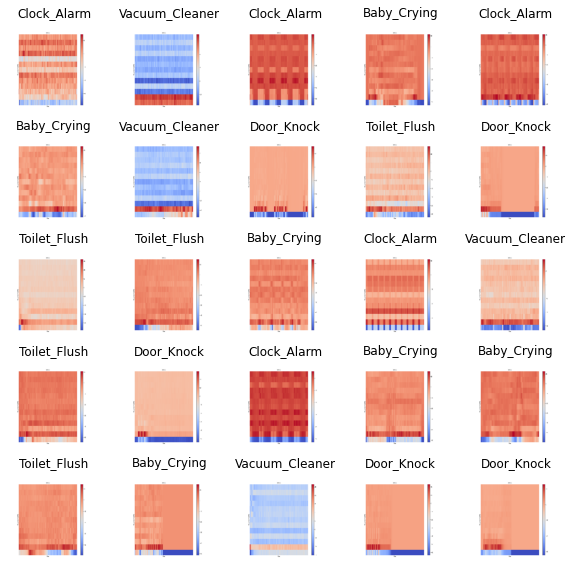

In [22]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
test_ds = prepare_for_training(labeled_ds)

In [0]:
class AcousticSoundModel(tf.keras.Model):
    def __init__(self):
        super(AcousticSoundModel, self).__init__()
        self.conv1 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop1 = Dropout(rate=0.2)
        self.pool1 = MaxPool2D(padding='SAME') ###### pooling 2x2. stride는 표기 x, 확인 ######
        
        self.conv2 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop2 = Dropout(rate=0.2) #20% dropout
        self.pool2 = MaxPool2D(padding='SAME')
        
        self.conv3 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop3 = Dropout(rate=0.2) #20% dropout
        self.pool3 = MaxPool2D(padding='SAME')
        
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = Dense(units=128, activation=tf.nn.relu)
        self.dense5 = Dense(units=5, activation=tf.nn.sigmoid) ### 일단 5. class 개수 추가되는 대로 변경
        
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.drop1(net)
        net = self.pool1(net)
        
        net = self.conv2(net)
        net = self.drop2(net)
        net = self.pool2(net)
        
        net = self.conv3(net)
        net = self.drop3(net)
        net = self.pool3(net)
        
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.dense5(net)
        return net

In [0]:
model = AcousticSoundModel()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['acc'])

In [27]:
model.summary()

ValueError: ignored

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=25, # batch크기 4, 전체 200개 샘플이니까 25
      epochs=training_epochs,
      validation_data=validation_generator,
      validation_steps=12)

In [8]:
# Explore your VM
!ls -la /
# Find disk space and RAM space
!df -h
!free -m

#What OS is your VM using:
!cat /etc/os-release

total 8064
drwxr-xr-x   1 root root    4096 May 18 03:56 .
drwxr-xr-x   1 root root    4096 May 18 03:56 ..
drwxr-xr-x   1 root root    4096 May 13 16:22 bin
drwxr-xr-x   2 root root    4096 Apr 24  2018 boot
drwxr-xr-x   1 root root    4096 May 13 16:29 content
drwxr-xr-x   1 root root    4096 May 13 16:59 datalab
drwxr-xr-x   5 root root     440 May 18 03:56 dev
-rw-r--r--   1 root root 4078115 May 13 16:29 dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl
-rw-r--r--   1 root root 4068717 May 13 16:29 dlib-19.18.0-cp36-cp36m-linux_x86_64.whl
-rwxr-xr-x   1 root root       0 May 18 03:56 .dockerenv
drwxr-xr-x   1 root root    4096 May 18 03:56 etc
drwxr-xr-x   2 root root    4096 Apr 24  2018 home
drwxr-xr-x   1 root root    4096 May 13 16:24 lib
drwxr-xr-x   2 root root    4096 May 13 16:18 lib32
drwxr-xr-x   2 root root    4096 Oct 29  2019 lib64
drwxr-xr-x   2 root root    4096 Oct 29  2019 media
drwxr-xr-x   2 root root    4096 Oct 29  2019 mnt
drwxr-xr-x   1 root root    4096 May 18 03:5

In [9]:
!ls  /root/.keras/datasets/

images	images.tar.gz


In [11]:
!ls  /root/.keras/datasets/images.tar.gz/

ls: cannot access '/root/.keras/datasets/images.tar.gz/': Not a directory
